In [19]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

In [20]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

tot_train_loss = [[],[]]
def train(args, model, device, train_loader, optimizer, epoch):
    train_loss = 0
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args.dry_run:
                break

    tot_train_loss[0].append(epoch)
    tot_train_loss[1].append(train_loss/len(train_loader))

tot_test_loss = [[],[]]
tot_test_acc = [[],[]]
ground_truth = []
predicted_result = []

def test(model, device, test_loader, epoch, args):
    global ground_truth
    global predicted_result
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            if epoch == args.epochs:
                predicted_result.extend(pred.to('cpu').numpy())
                ground_truth.extend(target.view_as(pred).to('cpu').numpy())
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    tot_test_loss[0].append(epoch)
    tot_test_loss[1].append(test_loss)
    tot_test_acc[0].append(epoch)
    tot_test_acc[1].append(100. * correct / len(test_loader.dataset))

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.316559
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.510761
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.712050
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.364917
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.422744

Test set: Average loss: 0.3107, Accuracy: 8883/10000 (89%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.703966
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.393543
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.227712
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.174131
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.490308

Test set: Average loss: 0.2591, Accuracy: 9079/10000 (91%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.168497
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.339265
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.458943
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.351030
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.128296

Test set: Average loss: 0.2499, Accuracy: 9116/10000 (91%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.285328
Train Epoch: 4 [12800/60000 (21%)]	Lo

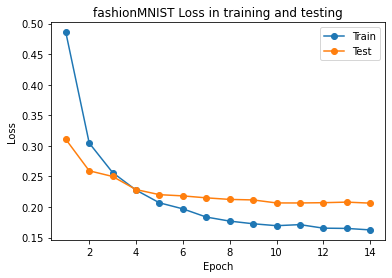

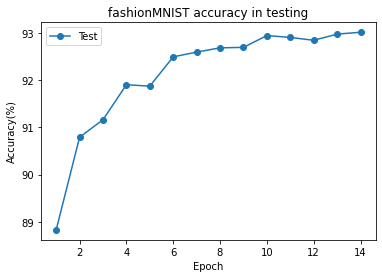

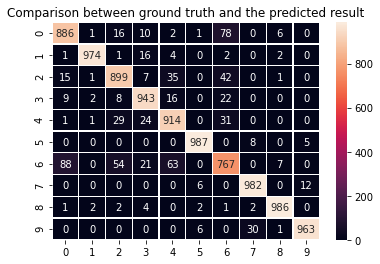

In [21]:
def fashionMNIST_main():
    parser = argparse.ArgumentParser(description='PyTorch fashionMNIST Example')
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=14, metavar='N',
                        help='number of epochs to train (default: 14)')
    parser.add_argument('--lr', type=float, default=1.0, metavar='LR',
                        help='learning rate (default: 1.0)')
    parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                        help='Learning rate step gamma (default: 0.7)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--dry-run', action='store_true', default=False,
                        help='quickly check a single pass')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=200, metavar='N',
                        help='how many batches to wait before logging training status')
    parser.add_argument('--save-model', action='store_true', default=False,
                        help='For Saving the current Model')
    args = parser.parse_args([])
    use_cuda = not args.no_cuda and torch.cuda.is_available()
    
    torch.manual_seed(args.seed)
    device = torch.device("cuda" if use_cuda else "cpu")

    train_kwargs = {'batch_size': args.batch_size}
    test_kwargs = {'batch_size': args.test_batch_size}
    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    dataset1 = datasets.FashionMNIST('../data', train=True, download=True,
                       transform=transform)
    dataset2 = datasets.FashionMNIST('../data', train=False,
                       transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    model = Net().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    for epoch in range(1, args.epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader, epoch, args)
        scheduler.step()

    if args.save_model:
        torch.save(model.state_dict(), "fasion_mnist_cnn.pt")

fashionMNIST_main()


# plot
plt.plot(tot_train_loss[0], tot_train_loss[1],'-o')
plt.plot(tot_test_loss[0], tot_test_loss[1], '-o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.title('fashionMNIST Loss in training and testing')
plt.show()

#plot Accuracy
plt.plot(tot_test_acc[0], tot_test_acc[1], '-o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy(%)')
plt.legend(['Test'])
plt.title('fashionMNIST accuracy in testing')
plt.show()

# plot last test confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
plt.figure()
ax = sns.heatmap(confusion_matrix(ground_truth, predicted_result), annot=True, linewidth=0.3, fmt='d')
plt.title('Comparison between ground truth and the predicted result')
plt.show()